# Introdução 

Este notebook é uma introdução ao sistema de Autoencoder e sua aplicação em imagens. O Autoencoder é uma rede neural que aprende a comprimir dados de entrada em uma representação de menor dimensão e, em seguida, reconstruir os dados de saída a partir dessa representação. O Autoencoder é composto por duas partes: um codificador e um decodificador. O codificador mapeia a entrada para a representação de menor dimensão e o decodificador mapeia a representação de volta para a saída original.

- Autor: [Kauã Henrique Da Silva](https://www.linkedin.com/in/kauahenr/)

## Objetivos

Este notebook tem como objetivo, apresentar o conceito de Autoencoder e sua aplicação em imagens. Para isso, será utilizado o dataset Fashion MNIST, que é um conjunto de dados de imagens de numeros manuscritos.

## Conteúdo

- Aplicações do Autoencoder
- Visualização de imagens codificadas
- Visualização de imagens reconstruídas
- Visualização de resultados de encoder e decoder
- Classificação de imagens com Autoencoder


# Setup

Pré-requisitos para execução deste notebook.

## Bibliotecas

caso não tenha alguma dessas bibliotecas instaladas, você pode instalar utilizando o comando `!pip install nome_da_biblioteca`.
as versões utilizadas estão listadas abaixo.

In [1]:
%pip install tensorflow==2.16.1 --quiet

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib

In [3]:
tf.__version__, np.__version__, matplotlib.__version__

('2.16.1', '1.26.4', '3.8.0')

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Reshape
from tensorflow.keras import utils as keras_utils
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt

## Database

Como mencionado anteriormente, o dataset utilizado será o mnist, que é um conjunto de dados de imagens de números manuscritos. O dataset é dividido em duas partes: treino e teste. O dataset de treino é composto por 60.000 imagens e o dataset de teste é composto por 10.000 imagens. Cada imagem possui dimensões de 28x28 pixels e é em escala de cinza.

### Download the databased



In [5]:
(x_train, y_train), (x_test, y_test) =  mnist.load_data()
print(f"""
  null values:
  x_train: {np.isnan(x_train).sum()}
  y_train: {np.isnan(y_train).sum()}
  x_test: {np.isnan(x_test).sum()}
  y_test: {np.isnan(y_test).sum()}    
  
  Shapes:
  x_train: {x_train.shape}
  y_train: {y_train.shape}
  x_test: {x_test.shape}
  y_test: {y_test.shape}
  
  Max/Min values:
  x_train: {x_train.max()}\{x_train.min()}
  y_train: {y_train.max()}\{y_train.min()}
  x_test: {x_test.max()}\{x_test.min()}
  y_test: {y_test.max()}\{y_test.min()}
""")


  null values:
  x_train: 0
  y_train: 0
  x_test: 0
  y_test: 0    
  
  Shapes:
  x_train: (60000, 28, 28)
  y_train: (60000,)
  x_test: (10000, 28, 28)
  y_test: (10000,)
  
  Max/Min values:
  x_train: 255\0
  y_train: 9\0
  x_test: 255\0
  y_test: 9\0



## Preprocessing

Para o pré-processamento dos dados, as imagens serão normalizadas para que os valores dos pixels estejam no intervalo [0, 1]. Além disso, as imagens serão redimensionadas para o tamanho 28x28x1 para que possam ser utilizadas como entrada para o Autoencoder.

### Normalization

A normalização dos dados é uma técnica comum em aprendizado de máquina para garantir que os dados estejam na mesma escala. Neste caso, os valores dos pixels das imagens serão normalizados para o intervalo [0, 1].

In [6]:
x_train, x_test = x_train / x_train[0].max(), x_test / x_test[0].max()
print(f"Min/Max: x_train={x_train[0].max()}/{x_train[0].min()}, x_test={x_test[0].max()}/{x_test[0].min()}")

Min/Max: x_train=1.0/0.0, x_test=1.0/0.0


### Train-test flatten

O flatten é uma técnica que transforma uma matriz em um vetor. Neste caso, as imagens de entrada serão transformadas de uma matriz 28x28 para um vetor de tamanho 784.

In [7]:
x_train_flatten = x_train.reshape(-1, np.prod(x_train.shape[1:]))
x_test_flatten = x_test.reshape(-1, np.prod(x_test.shape[1:]))
x_train_flatten.shape, x_test_flatten.shape

((60000, 784), (10000, 784))

### Train-test conv

O dataset de treino e teste será redimensionado para o tamanho 28x28x1 para que possam ser utilizados como entrada para o Autoencoder. O tamanho 1 indica que as imagens são em escala de cinza.

In [8]:
x_train_conv, x_test_conv = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train_conv.shape, x_test_conv.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### test categories

O valor y do dataset está em formato numérico este formato não é adequado para o treinamento de uma rede neural. Portanto, os valores de y serão convertidos para o formato categórico.

- 1 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- 2 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
- (...)

In [9]:
y_train, y_test = keras_utils.to_categorical(y_train), keras_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

# Visualizing Image Dimensionality Reduction

Nesta seção, será utilizado um Autoencoder mais simples para comprimir as imagens de entrada em uma representação de menor dimensão e, em seguida, reconstruir as imagens de saída a partir dessa representação. O Autoencoder será treinado usando uma arquitetura de rede neural simples com uma camada de entrada, uma camada oculta e uma camada de saída.

In [10]:
QTD_NEURO_ENCODER = 128 # Quantidade de neurônios na camada de encoder

## Building and Training the Model

A arquitetura do Autoencoder é composta por uma camada de entrada, uma camada oculta e uma camada de saída. A camada de entrada possui 784 neurônios, que correspondem ao número de pixels das imagens de entrada. A camada oculta possui 128 neurônios, que correspondem à representação de menor dimensão das imagens. A camada de saída possui 784 neurônios, que correspondem ao número de pixels das imagens de saída.

In [11]:
autoencoder_falleng = Sequential()
autoencoder_falleng.add(Input(shape=(x_train_flatten.shape[1],)))
autoencoder_falleng.add(Dense(QTD_NEURO_ENCODER, activation='relu'))
autoencoder_falleng.add(Dense(x_train_flatten.shape[1], activation='sigmoid'))
autoencoder_falleng.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
%%time
autoencoder_falleng.fit(
  x_train_flatten, x_train_flatten,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[CSVLogger('csv_logger_autoencor_falleng.csv', append=False)],
  validation_data=(x_test_flatten, x_test_flatten)
);

CPU times: user 1min 11s, sys: 11.4 s, total: 1min 22s
Wall time: 50.6 s


### Os autoencoders são divididos em duas partes:

- Encoder: é a parte da rede que aprende a representação de menor dimensão dos dados de entrada.
- Decoder: é a parte da rede que reconstrói os dados de saída a partir da representação de menor dimensão.

In [13]:
img_flatten = Input(shape=(x_train_flatten.shape[1],))
img_encoded_flatten = Input(shape=(QTD_NEURO_ENCODER,))

encoder_flatting = Model(img_flatten, autoencoder_falleng.layers[0](img_flatten))
decoder_flatting = Model(img_encoded_flatten, autoencoder_falleng.layers[-1](img_encoded_flatten))

## Predictions

Nesta seção, as imagens de entrada serão comprimidas em uma representação de menor dimensão usando o codificador e, em seguida, reconstruídas usando o decodificador. As imagens de entrada, representação de menor dimensão e imagens de saída serão visualizadas para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens.

In [14]:
imgs_encoded_flatting = encoder_flatting.predict(x_test_flatten)
imgs_decoded_flatting = decoder_flatting.predict(imgs_encoded_flatting)
imgs_encoded_flatting.shape, imgs_decoded_flatting.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


((10000, 128), (10000, 784))

## Visualizing the Results

Nesta seção será apresentado os resultados obtidos com o Autoencoder. Será exibido as imagens de entrada, representação de menor dimensão e imagens de saída para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens. Além disso, será calculado a quantidade de informação preservada pelo Autoencoder, juntamente com a similaridade entre as imagens de entrada e saída.


Encoded size: 4.88 MB -> Predicted size: 29.91 MB. Reduction size: 25.02 MB
Percentage reduction: 83.67%
Similarity percentage: 98.79%


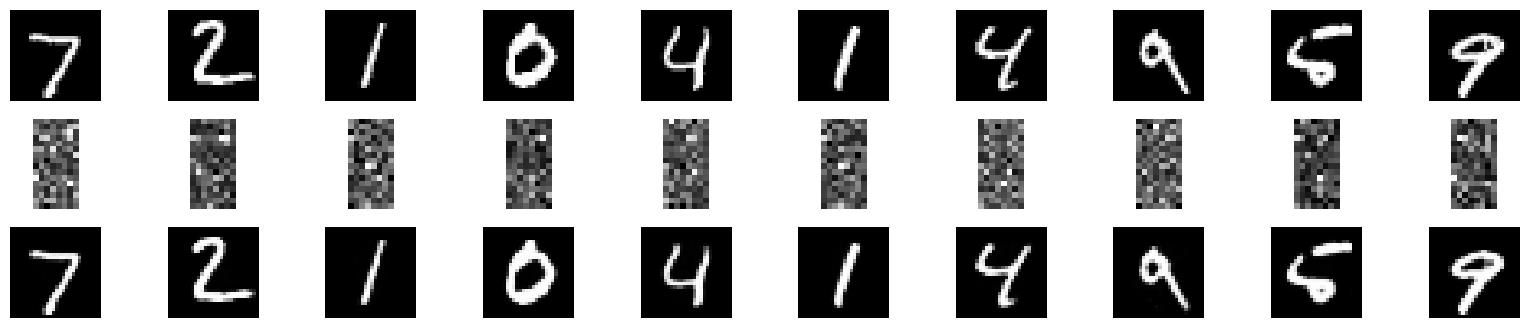

In [15]:
size_encoded = imgs_encoded_flatting.__sizeof__()
size_pred = imgs_decoded_flatting.__sizeof__()
size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024
reduction_size = abs(size_encoded_mb - size_pred_mb)
reduction_rate = size_pred_mb / size_encoded_mb
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
mean_diff = np.mean(np.abs(x_test_flatten - imgs_decoded_flatting))
similarity_percentage = (1 - mean_diff) * 100

print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")

QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(imgs_encoded_flatting[i].reshape(16, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(imgs_decoded_flatting[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  
plt.show()

# Visualizing Image Dimensionality Reduction - Categorical

Nesta seção, será utilizado um Autoencoder semelhante ao anterior, mas com uma adição que é a categorização das imagens. O Autoencoder será treinado para comprimir as imagens de entrada em uma representação de menor dimensão e, em seguida, reconstruir as imagens de saída a partir dessa representação. Além disso, as imagens comprimidas serão categorizadas em 10 classes diferentes.

## Building and Training the Model

Como mencionado anteriormente, essa seção vai demonstrar a utilização tanto do encoder quanto da rede neural para categorizar as imagens.

In [16]:
QTD_NEURO_ENCODER = 32

#### Encoding Model

O modelo de codificação é responsável por mapear as imagens de entrada para a representação de menor dimensão. O modelo de codificação é composto por uma camada de entrada, uma camada oculta e uma camada de saída. A camada de entrada possui 784 neurônios, que correspondem ao número de pixels das imagens de entrada. A camada oculta possui 32 neurônios, que correspondem à representação de menor dimensão das imagens. A camada de saída possui 784 neurônios, que correspondem ao número de pixels das imagens de saída.

In [17]:
autoencoder_falleng_2 = Sequential()
autoencoder_falleng_2.add(Input(shape=(x_train_flatten.shape[1],)))
autoencoder_falleng_2.add(Dense(QTD_NEURO_ENCODER, activation='relu'))
autoencoder_falleng_2.add(Dense(x_train_flatten.shape[1], activation='sigmoid'))
autoencoder_falleng_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
%%time
autoencoder_falleng_2.fit(
  x_train_flatten, x_train_flatten,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[CSVLogger('csv_logger_autoencor_falleng_2.csv', append=False)]
);

CPU times: user 50.2 s, sys: 7.68 s, total: 57.9 s
Wall time: 34.8 s



Aqui, possui a divisão do modelo de codificação e do modelo de categorização. O modelo de codificação é responsável por mapear as imagens de entrada para a representação de menor dimensão.

In [19]:
img_flatten_2 = Input(shape=(x_train_flatten.shape[1],))
img_encoded_flatten_2 = Input(shape=(QTD_NEURO_ENCODER,))

encoder_flatting_2 = Model(img_flatten_2, autoencoder_falleng_2.layers[0](img_flatten_2))
decoder_flatting_2 = Model(img_encoded_flatten_2, autoencoder_falleng_2.layers[-1](img_encoded_flatten_2))

#### Category Model no encoding

O modelo de categorização é responsável por categorizar as imagens comprimidas em 10 classes diferentes sem utilizar o modelo de codificação. O modelo de categorização é composto por uma camada de entrada, duas camada oculta e uma camada de saída. A camada de entrada possui 784 neurônios, que correspondem à representação da imagem sem compressão. A camada oculta possui 408 neurônios, que correspondem à representação intermediária da imagem. A camada de saída possui 10 neurônios, que correspondem às 10 classes diferentes.

In [40]:
units_count = int((x_train_flatten.shape[1] + QTD_NEURO_ENCODER) / 2)
units_count

408

In [41]:
network_no_encoded = Sequential()
network_no_encoded.add(Input(shape=(x_train_flatten.shape[1],)))
network_no_encoded.add(Dense(units_count, activation='relu'))
network_no_encoded.add(Dense(units_count, activation='relu'))
network_no_encoded.add(Dense(10, activation='softmax'))
network_no_encoded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
params_no_encoded = network_no_encoded.count_params()
params_no_encoded

491242

In [42]:
%%time
network_no_encoded.fit(
    x_train_flatten, y_train, 
    epochs=50, batch_size=256, verbose=0,
    callbacks=[CSVLogger('cv2_logger_classifier_no_encoded.csv', append=False)],
    validation_data=(x_test_flatten, y_test),
);

CPU times: user 1min 44s, sys: 9.11 s, total: 1min 53s
Wall time: 53.2 s


#### Category Model with encoding

O modelo de categorização é responsável por categorizar as imagens comprimidas em 10 classes diferentes utilizando o modelo de codificação. O modelo de categorização é composto por uma camada de entrada, duas camada oculta e uma camada de saída. A camada de entrada possui 31 neurônios, que correspondem à representação de menor dimensão das imagens. A camada oculta possui 21 neurônios, que correspondem à representação intermediária da imagem. A camada de saída possui 10 neurônios, que correspondem às 10 classes diferentes.

In [44]:
units_count = int((QTD_NEURO_ENCODER + y_train.shape[1]) / 2)
units_count

21

In [45]:
network_encoded = Sequential()
network_encoded.add(Input(shape=(QTD_NEURO_ENCODER,)))
network_encoded.add(Dense(units_count, activation='relu'))
network_encoded.add(Dense(units_count, activation='relu'))
network_encoded.add(Dense(10, activation='softmax'))
network_encoded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
params_encoded = network_encoded.count_params()
params_encoded

1375

In [46]:
%%time
network_encoded.fit(
  encoder_flatting_2.predict(x_train_flatten), y_train, 
  epochs=100, batch_size=256, verbose=0, 
  callbacks=[CSVLogger('cv2_logger_classifier_encoded.csv', append=False)],
  validation_data=(encoder_flatting_2.predict(x_test_flatten), y_test)
);

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CPU times: user 1min 24s, sys: 16.5 s, total: 1min 41s
Wall time: 1min 15s


## Predictions

Nesta seção, as imagens de entrada serão comprimidas em uma representação de menor dimensão usando o codificador e, em seguida, reconstruídas usando o decodificador. As imagens de entrada, representação de menor dimensão e imagens de saída serão visualizadas para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens. Além disso, as imagens comprimidas serão categorizadas em 10 classes diferentes.

In [47]:
imgs_encoded_x_train_flatting_2 = encoder_flatting_2.predict(x_train_flatten)
imgs_encoded_x_test_flatting_2 = encoder_flatting_2.predict(x_test_flatten)
imgs_decoded_x_train_flatting_2 = decoder_flatting_2.predict(imgs_encoded_x_train_flatting_2)
imgs_decoded_x_test_flatting_2 = decoder_flatting_2.predict(imgs_encoded_x_test_flatting_2)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [48]:
%%time
predicitions_no_encoded_categorical = network_no_encoded.predict(x_test_flatten)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
CPU times: user 11.3 s, sys: 292 ms, total: 11.6 s
Wall time: 3.59 s


In [49]:
%%time
temp = encoder_flatting_2.predict(x_test_flatten)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CPU times: user 634 ms, sys: 87.7 ms, total: 722 ms
Wall time: 677 ms


In [50]:
%time
predicitions_encoded_categorical = network_encoded.predict(temp)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [51]:
predicitions_no_encoded = np.argmax(predicitions_no_encoded_categorical, axis=1)
predicitions_encoded = np.argmax(predicitions_encoded_categorical, axis=1)
predicitions_no_encoded[:10], predicitions_encoded[:10], np.argmax(y_test[:10], axis=1)

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

## Visualizing the Results

Nesta seção será apresentado os resultados obtidos com o Autoencoder. Será exibido as imagens de entrada, representação de menor dimensão e imagens de saída para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens. Além disso, será calculado a quantidade de informação preservada pelo Autoencoder, a similaridade entre as imagens de entrada e saída. E a acurácia do modelo de categorização.

Encoded size: 1.22 MB -> Predicted size: 29.91 MB. Reduction size: 28.69 MB
Percentage reduction: 95.92%
Similarity percentage: 96.74%
No encoded params: 491242 -> Encoded params: 1375. Reduction: 99.72%


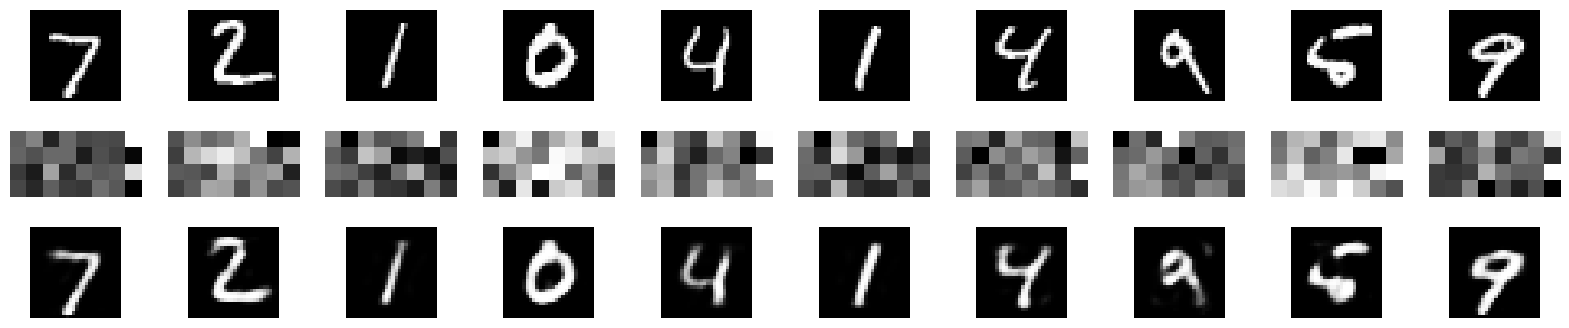

In [52]:
size_encoded = imgs_encoded_x_test_flatting_2.__sizeof__()
size_pred = imgs_decoded_x_test_flatting_2.__sizeof__()
size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024
reduction_size = abs(size_encoded_mb - size_pred_mb)
reduction_rate = size_pred_mb / size_encoded_mb
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
mean_diff = np.mean(np.abs(x_test_flatten - imgs_decoded_x_test_flatting_2))
similarity_percentage = (1 - mean_diff) * 100
reduction_porcentage = (1 - (params_encoded / params_no_encoded)) * 100


print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")
print(f"No encoded params: {params_no_encoded} -> Encoded params: {params_encoded}. Reduction: {reduction_porcentage:.2f}%")


QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(imgs_encoded_x_test_flatting_2[i].reshape(4, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(imgs_decoded_x_test_flatting_2[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  
plt.show()

In [53]:
accuracy_no_encoded = np.mean(predicitions_no_encoded == np.argmax(y_test, axis=1))
accuracy_encoded = np.mean(predicitions_encoded == np.argmax(y_test, axis=1))

print(f"Accuracy no encoded: {accuracy_no_encoded:.2f} -> Accuracy encoded: {accuracy_encoded:.2f}")
print(f"Accuracy difference: {abs(accuracy_encoded - accuracy_no_encoded):.2f}")

Accuracy no encoded: 0.98 -> Accuracy encoded: 0.95
Accuracy difference: 0.03


# Visualizing Image Dimensionality Reduction - Deep Learning

Nesta seção, será utilizado um Autoencoder mais complexo para comprimir as imagens de entrada em uma representação de menor dimensão e, em seguida, reconstruir as imagens de saída a partir dessa representação. O Autoencoder será treinado usando uma arquitetura de rede neural mais complexa com várias camadas de entrada, várias camadas ocultas e várias camadas de saída.

## Building and Training the Model

Faça uma breve descrição da arquitetura do Autoencoder utilizado. A entrada, vai receber uma imagem de 784, a camada encoder vai reduzir a imagem para 128, a camada de saída vai reconstruir a imagem para 784.

In [54]:
units_count = int((x_train_flatten.shape[1] + y_train.shape[1]) / 2)
QTD_NEURO_ENCODER = 32
QTD_NEURO_ENCODER, units_count

(32, 397)

In [55]:
autoencoder_flattening_deep = Sequential()
autoencoder_flattening_deep.add(Input(shape=(x_train_flatten.shape[1],)))
autoencoder_flattening_deep.add(Dense(units_count, activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 2), activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 4), activation='relu'))
autoencoder_flattening_deep.add(Dense(QTD_NEURO_ENCODER, activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 4), activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 2), activation='relu'))
autoencoder_flattening_deep.add(Dense(units_count, activation='relu'))
autoencoder_flattening_deep.add(Dense(x_train_flatten.shape[1], activation='sigmoid'))
autoencoder_flattening_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Modelos de codificação e decodificação

Esta seção está destinada a pegar os pesos do modelo do autoencoder e separar em dois modelos, um para codificação e outro para decodificação.

In [95]:
encoder_flatting_deep = Model(autoencoder_flattening_deep.layers[0].input, autoencoder_flattening_deep.layers[3].output)
decoder_flatting_deep = Model(autoencoder_flattening_deep.layers[3].input, autoencoder_flattening_deep.layers[-1].output)

### Treinamento do modelo

Treinamento simples do modelo, sem muitas informações.

In [ ]:
%%time

autoencoder_flattening_deep.fit(
  x_train_flatten, x_train_flatten,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[ CSVLogger('cv2_logger_autoencor_falleng_deep.csv', append=False) ],
  validation_data=(x_test_flatten, x_test_flatten)
)

### Predictions

Nesta seção, as imagens de entrada serão comprimidas em uma representação de menor dimensão usando o codificador e, em seguida, reconstruídas usando o decodificador. As imagens de entrada, representação de menor dimensão e imagens de saída serão visualizadas para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens.

In [59]:
imgs_encoded_x_test_flatting_deep = encoder_flatting_deep.predict(x_test_flatten)
imgs_decoded_x_test_flatting_deep = decoder_flatting_deep.predict(imgs_encoded_x_test_flatting_deep)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


### Exibição dos resultados

Nesta seção será apresentado os resultados obtidos com o Autoencoder. Será exibido as imagens de entrada, representação de menor dimensão e imagens de saída para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens. Além disso, será calculado a quantidade de informação preservada pelo Autoencoder, a similaridade entre as imagens de entrada e saída.

Encoded size: 1.22 MB -> Predicted size: 29.91 MB. Reduction size: 28.69 MB
Percentage reduction: 95.92%
Similarity percentage: 97.65%


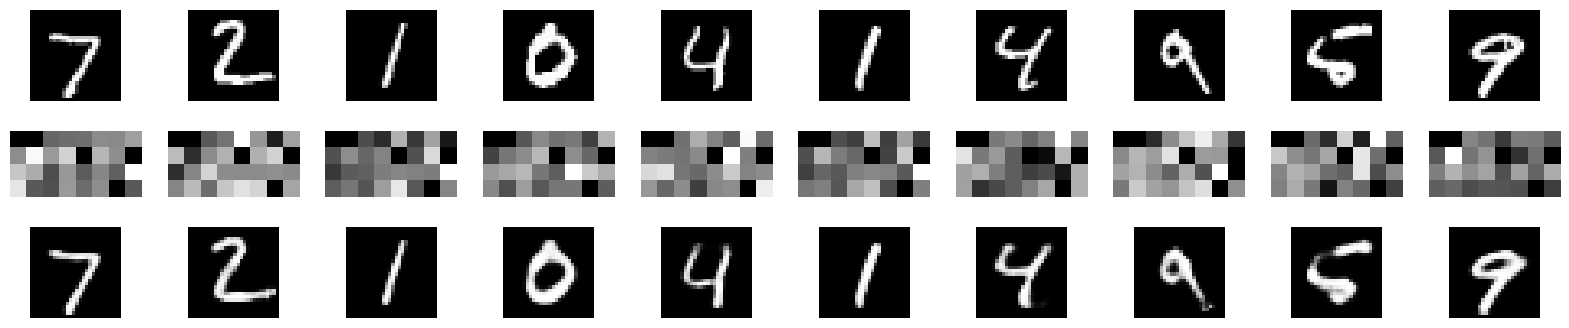

In [60]:
size_encoded = imgs_encoded_x_test_flatting_deep.__sizeof__()
size_pred = imgs_decoded_x_test_flatting_deep.__sizeof__()

size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024

reduction_size = abs(size_encoded_mb - size_pred_mb)
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
similarity_percentage = (1 - np.mean(np.abs(x_test_flatten - imgs_decoded_x_test_flatting_deep))) * 100

print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")


QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(imgs_encoded_x_test_flatting_deep[i].reshape(4, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(imgs_decoded_x_test_flatting_deep[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  
plt.show()

# Visualizing Image Dimensionality Reduction - Convolutional Neural Networks

Nesta seção, será utilizado um Autoencoder mais complexo para comprimir as imagens de entrada em uma representação de menor dimensão e, em seguida, reconstruir as imagens de saída a partir dessa representação. O Autoencoder será treinado usando uma arquitetura de rede neural convolucional com várias camadas de convolução, max pooling e camadas de reconstrução.

In [75]:
autoencoder_flattening_conv = Sequential()

autoencoder_flattening_conv.add(Input(shape=(x_train_conv.shape[1], x_train_conv.shape[2], x_train_conv.shape[3])))
autoencoder_flattening_conv.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder_flattening_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_flattening_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_flattening_conv.add(MaxPooling2D((2, 2), padding='same'))
autoencoder_flattening_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2)))

autoencoder_flattening_conv.add(Flatten())
autoencoder_flattening_conv.add(Reshape((4, 4, 8)))

autoencoder_flattening_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_flattening_conv.add(UpSampling2D((2, 2)))
autoencoder_flattening_conv.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_flattening_conv.add(UpSampling2D((2, 2)))
autoencoder_flattening_conv.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder_flattening_conv.add(UpSampling2D((2, 2)))
autoencoder_flattening_conv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder_flattening_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Encoding e Decoding Model

Esta seção está destinada a pegar os pesos do modelo do autoencoder e separar o peso para o modelo de codificação. O modelo de decodificação é inviável de ser separado, pois ele é dependente de camadas de UpSampling2D e Reshape.

In [90]:
encoder_conv = Model(autoencoder_flattening_conv.layers[0].input, autoencoder_flattening_conv.layers[5].output)

In [78]:
autoencoder_flattening_conv.fit(
  x_train_conv, x_train_conv,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[CSVLogger('cv2_logger_autoencor_falleng_conv.csv', append=False)],
  validation_data=(x_test_conv, x_test_conv)
)

### Predictions

Foi utilizado o modelo completo para fazer a parte de decodificação, e a parte de codificação foi feita separadamente.

In [91]:
encoded_imgs_conv = encoder_conv.predict(x_test_conv)
decoded_imgs_conv = autoencoder_flattening_conv.predict(x_test_conv)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


#### Visualizing the Results

Nesta seção será apresentado os resultados obtidos com o Autoencoder. Será exibido as imagens de entrada, representação de menor dimensão e imagens de saída para verificar a capacidade do Autoencoder de comprimir e reconstruir as imagens. Além disso, será calculado a quantidade de informação preservada pelo Autoencoder, a similaridade entre as imagens de entrada e saída.

Encoded size: 4.88 MB -> Predicted size: 29.91 MB. Reduction size: 25.02 MB
Percentage reduction: 83.67%
Similarity percentage: 97.28%


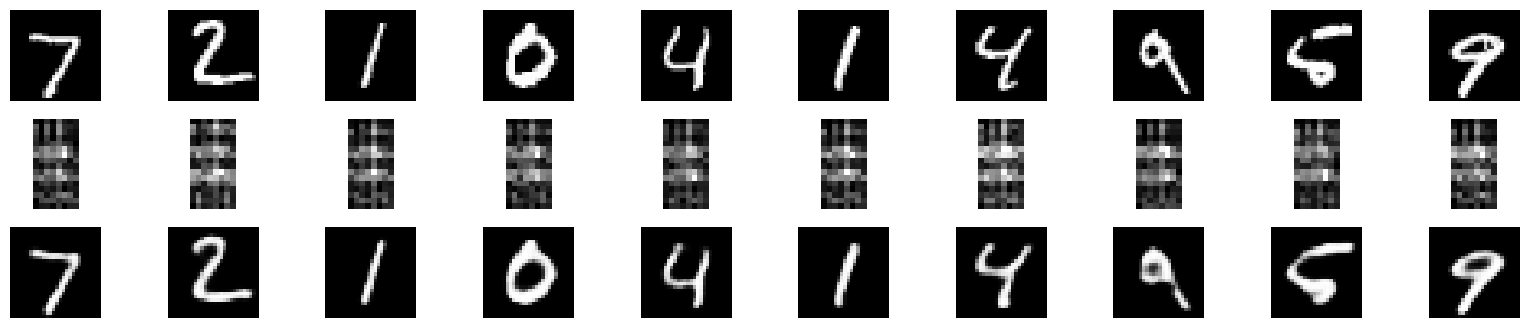

In [92]:
size_encoded = encoded_imgs_conv.__sizeof__()
size_pred = decoded_imgs_conv.__sizeof__()

size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024

reduction_size = abs(size_encoded_mb - size_pred_mb)
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
similarity_percentage = (1 - np.mean(np.abs(x_test_conv - decoded_imgs_conv))) * 100

print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")


QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(encoded_imgs_conv[i].reshape(16, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(decoded_imgs_conv[i].reshape(28, 28, 1), cmap='gray')
  plt.axis('off')
  
plt.show()